In [2]:
import planetspy as ps
import planetspy.engines as eng
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [100]:
import planetspy as ps
import planetspy.engines as eng
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

class record:
    loc = []
    def __init__(self, bodies):
        self.loc.append(np.copy(bodies[0][::,0:3]))
    def run(self, simclass):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
        return False

bodies = [
    np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.371*10**6, 5.972*10**24],
              [0, 6.371*10**6 + 400*10**3, 0, -10, 0, 0, 1, 1000],
              [6.371*10**6 + 385*10**6, 0, 0, 0, 10**3, 0, 1737.5*10**3, 7.35*10**22]
             ])
    , [["Earth", "r-"], ["ISS", "b-"],["Moon", "m-"]]
]

recinst = record(bodies)
collinst = collisions()
sim = ps.Simulate(eng.PP, 100, 10, bodies, bailout = 60*60*24*30, envmod=[recinst, collinst])
sim.main_loop()
sim.steps

259200.0

In [101]:
class collisions:
    loc = []
    def run(self, simclass):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
        x_dist = np.hstack(simclass.bodies[0][::,0]) - np.vstack(simclass.bodies[0][::,0])
        y_dist = np.hstack(simclass.bodies[0][::,1]) - np.vstack(simclass.bodies[0][::,1])
        z_dist = np.hstack(simclass.bodies[0][::,2]) - np.vstack(simclass.bodies[0][::,2])
        radii_add = np.hstack(simclass.bodies[0][::,6]) + np.vstack(simclass.bodies[0][::,6])
        x_distsq = x_dist**2
        y_distsq = y_dist**2
        z_distsq = z_dist**2
        distsq = (x_distsq + y_distsq + z_distsq)
        dist = np.sqrt(distsq)
        dist = np.where(dist != 0, dist, np.inf)
        distsq = 1/np.where(distsq != 0, distsq, np.inf) 
        dist = np.where(dist >= radii_add , dist, 0)
        collided_bodies = np.where(dist == 0)
        coll_bodies = []
        for i in range(0, len(collided_bodies[0])//2):
            coll_bodies.append([collided_bodies[0][i], collided_bodies[1][i]])
        if len(coll_bodies) ==0:
            return False
        def combine(F,L):
            x = (simclass.bodies[0][F, 0]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 0]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            y = (simclass.bodies[0][F, 1]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 1]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            z = (simclass.bodies[0][F, 2]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 2]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            vx = (simclass.bodies[0][F, 3]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 3]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            vy = (simclass.bodies[0][F, 4]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 4]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            vz = (simclass.bodies[0][F, 5]*simclass.bodies[0][F, 7] + simclass.bodies[0][L, 5]*simclass.bodies[0][L, 7])/(simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7])
            r = (simclass.bodies[0][F, 6]**3 + simclass.bodies[0][L, 6]**3)**(1/3)
            m = simclass.bodies[0][F, 7] + simclass.bodies[0][L, 7]
            return np.array([x, y, z ,vx, vy, vz, r, m])
        for i in range(len(coll_bodies)):
            simclass.bodies[0][coll_bodies[i][0]] = combine(coll_bodies[i][0], coll_bodies[i][1])
        simclass.bodies[0] = np.delete(simclass.bodies[0], np.array(coll_bodies)[::,1], 0)
        for i in range(len(coll_bodies)):
            simclass.bodies[1][coll_bodies[i][0]][0] = simclass.bodies[1][coll_bodies[i][0]][0] + simclass.bodies[1][coll_bodies[i][1]][0]
        def delete(list_, n):
            list_ = list_[:n] + list_[n+1:]
            return list_
        for i in range(len(coll_bodies)):
            simclass.bodies[1] = delete(simclass.bodies[1], np.array(coll_bodies)[i,1])
        simclass.set_dirty()
        return False



<IPython.core.display.Javascript object>


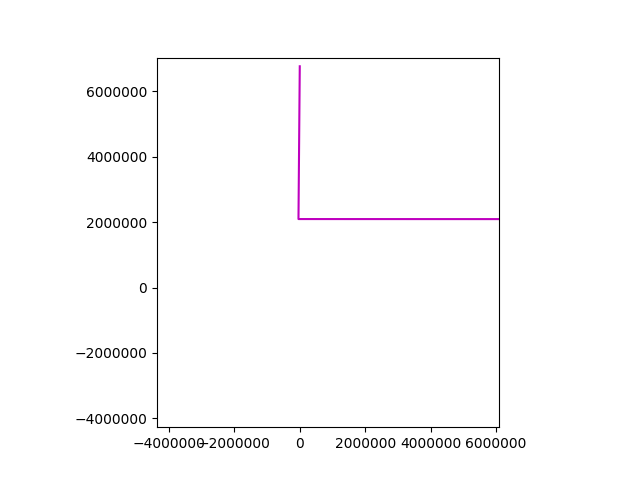

In [110]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


def plot_relative(b):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for j in range(0,len(bodies[0])):
        ax.plot([i[j][0] - i[b][0] for i in recinst.loc], [i[j][1] - i[b][1] for i in recinst.loc], [i[j][2] - i[b][2] for i in recinst.loc], bodies[1][j][1])
    ax.scatter(0,0,0,'ro')
    ax.set_aspect("equal")
    plt.show()
    return ax
                                                                                                       
p = plot_relative(0)
#p.set_xlim(-6.371*10**6 + 900*10**3, 6.371*10**6 + 900*10**3)
#p.set_ylim(-6.371*10**6 + 900*10**3, 6.371*10**6 + 900*10**3)

<IPython.core.display.Javascript object>


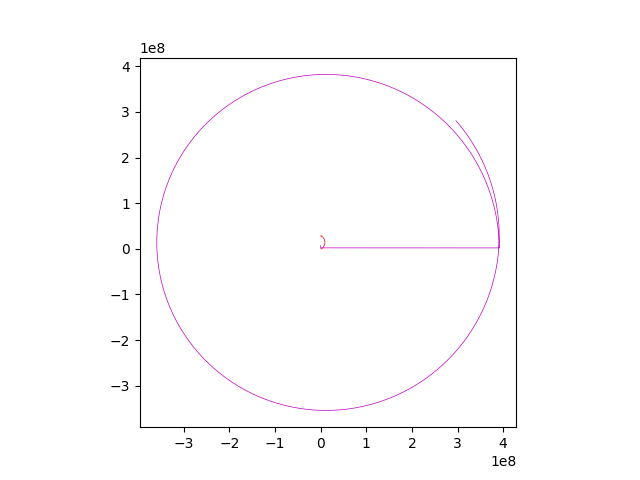

[array([[ 1.16588471e+06,  2.84464761e+07,  0.00000000e+00,
         8.13769329e+00,  3.00085360e+00,  0.00000000e+00,
         6.37100000e+06,  5.97200000e+24],
       [ 2.96640884e+08,  2.80675438e+08,  0.00000000e+00,
        -6.61201419e+02,  7.56175541e+02,  0.00000000e+00,
         1.73750000e+06,  7.35000000e+22]]), [['EarthISS', 'r-'], ['Moon', 'm-']]]


In [112]:
fig = plt.figure()
ax = fig.add_subplot(111)
for j in range(0,len(bodies[0])):
    ax.plot([i[j][0] for i in recinst.loc], [i[j][1] for i in recinst.loc], bodies[1][j][1], linewidth = .5)

ax.set_aspect("equal")
plt.show()
print(bodies)

<IPython.core.display.Javascript object>


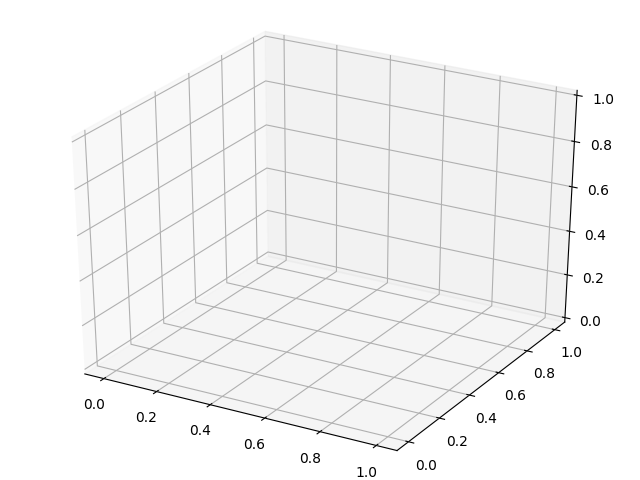

In [67]:
#animation 
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax = p3.Axes3D(fig)
particles = ax.plot([],[],[], 'ko')
def animate(i):
    global recinst, ax, fig
                      #all x positions.    , all y positions.    , all z positions
    particles.set_data(recinst.loc[i][::,0], recinst.loc[i][::,1], recinst.loc[i][::,2])
    return particles
ani = animation.FuncAnimation(fig, animate, frames=600, fargs= (bodies, recinst.loc), interval=10, blit=False, init_func=record.__init__)
plt.show()

In [ ]:
###  normally distributed dust cloud  ####

